## Kamil Kałużny 148121, Adam Wiatrowski 148510, Kacper Perz 145261

In [1]:
import warnings
import pandas as pd
import logging

# !!!!!!!
# for numpy >= 2.0.0 pipeline is very fast
# but catboost only works with numpy <= 1.26.x

from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler


from config import RANDOM_STATE, ModelConfig, ScoringConfig
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
plt.style.use("ggplot")


from utils import (
    list_unique_object_values,
    preprocess_medical_data,
    missing_values_stats,
    binarize_decision_class,
    full_pipeline,
)

### AP

In [2]:
df = pd.read_excel(
    "../data/ap_pro_data.xls", sheet_name="Physicians - Continuous", skiprows=2
)

In [3]:
list_unique_object_values(df)

Sex ['female' 'male']
PainDur [144 120 11 24 3 32 48 96 5 72 20 7 4 12 2 9 10 60 1 8 168 216 192 6 1.5
 36 3.5 30 38 23 15 29 2.5 4.5 18 35 22 16 13 28 14 45 6.5 5.2 6.2 84 17
 '?' 108 51 0.5 15.5 5.5 240]
PainSite ['lower_abdomen' 'other' 'RLQ']
PainType ['constant' 'intermittent' '?']
Vomiting ['yes' 'no' '?']
PrevVis ['no' 'yes' '?']
Temp [37.4 35.7 35.9 37.8 38.2 37.3 37.5 38.4 37.6 36.3 38 38.3 37.1 37.2 35.6
 38.1 36.2 36.4 38.8 35.4 36.7 35.8 36 38.6 36.5 38.9 36.9 35.5 38.7 35.3
 36.6 39.8 36.1 37.7 36.8 40 35.2 37 '?' 35 35.1 37.9 39.9 39.7 39 39.6
 40.3 38.5 39.1 39.5 34.8 39.4]
TendSite ['lower_abdomen' 'other' 'RLQ' '?']
Guard ['no' 'yes' '?']
RebTend ['no' 'yes' '?']
PainShift ['no' 'yes' '?']
WBC ['?' 18.6 17 9.8 13.3 5.9 6.9 7.2 6.6 4.9 20 13.1 7.6 5.6 10.7 15.9 9.3
 3.6 4.6 10.2 2.3 14.3 9.7 20.3 14 31.6 11.2 6.8 7.8 11.9 9.6 23 10.6 14.1
 7.7 16.6 11.6 7.5 13.2 4.1 16.2 28 10.3 22.8 17.2 13 10.9 10.4 23.2 2.7
 11.1 15 19.7 8.3 7.4 11.7 21 9 4.4 7.3 6.1 10 25.3 16.3 12.

In [4]:
missing_values_stats(df.replace("?", None))

           Missing Values  Percentage
WBC                   354   77.461707
TendSite               55   12.035011
PainShift               9    1.969365
Temp                    7    1.531729
PrevVis                 5    1.094092
RebTend                 5    1.094092
PainType                4    0.875274
Vomiting                4    0.875274
Guard                   3    0.656455
PainDur                 1    0.218818


In [5]:
target_column = "Triage"
yes_no_features = ["Vomiting", "Guard", "RebTend", "PrevVisPainShift"]
onehot_features = [
    "Sex",
    "PainSite",
    "PainType",
]
num_features = [
    "Temp",
    "PainDur",
]

drop_features = ["VisitID", "RecordID", "Observer", "WBC"]  # WBC is 77.461707% NaN
cat_features = []
ordinal_features = []
keep_features = []


X, y = preprocess_medical_data(
    df,
    target_column=target_column,
    num_features=num_features,
    onehot_features=onehot_features,
    yes_no_features=yes_no_features,
    drop_features=drop_features,
    cat_features=cat_features,
    ordinal_features=ordinal_features,
    keep_features=keep_features,
)

In [6]:
y.unique()

array(['discharge', 'consult', 'observation'], dtype=object)

In [7]:
class_sequence = {"discharge": 0, "consult": 1, "observation": 2}
y = y.map(class_sequence)

2025-03-30 20:29:23,876 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 20:29:23,876 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 20:29:23,878 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:29:23,878 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:29:24,172 - SuperClassifier - INFO -   CV Score: 0.5654 ± 0.0630
2025-03-30 20:29:24,172 - SuperClassifier - INFO -   CV Score: 0.5654 ± 0.0630
2025-03-30 20:29:24,173 - SuperClassifier - INFO -   Test Score: 0.5851
2025-03-30 20:29:24,173 - SuperClassifier - INFO -   Test Score: 0.5851
2025-03-30 20:29:24,174 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 20:29:24,174 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 20:29:24,174 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:29:24,174 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:29:40,544 - SuperClassifier - INFO -   CV Score: 0.5871 ± 0.0310
2025-03-30 20:29:40,544

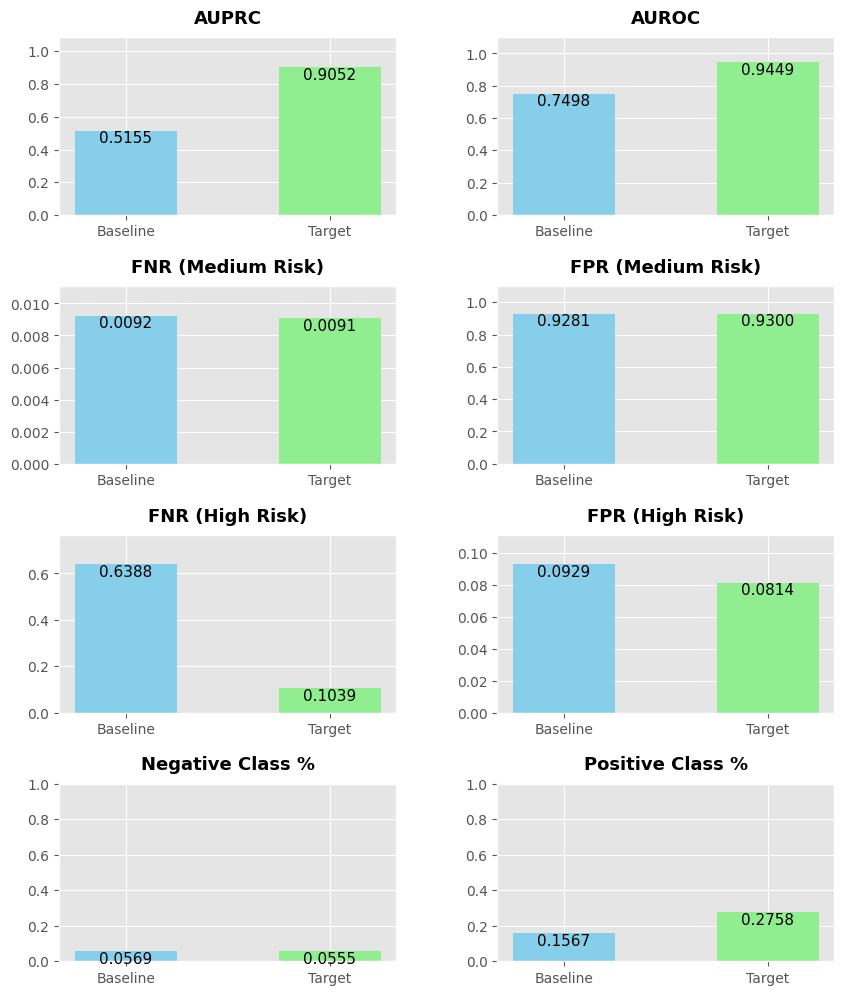

2025-03-30 20:29:42,284 - ClassifierEvaluation - INFO - Results plot saved as 'ap_ROBUST_CATBOOST.png'


In [8]:
y_binary = binarize_decision_class(y)

baseline_config = ModelConfig(
    name="Baseline",
    estimator_class="sklearn.linear_model.LogisticRegression",
    params={"random_state": RANDOM_STATE, "max_iter": 1000},
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

target_name = "ap_ROBUST_CATBOOST"
target_config = ModelConfig(
    name="Target",
    estimator_class="sklearn.pipeline.Pipeline",
    params={
        "steps": [
            ("scaler", RobustScaler()),
            (
                "classifier",
                CatBoostClassifier(
                    iterations=1000,
                    learning_rate=0.1,
                    depth=6,
                    random_state=RANDOM_STATE,
                    verbose=0,  # Suppress CatBoost's internal logging
                ),
            ),
        ]
    },
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

_, _ = full_pipeline(
    X=X,
    y=y,
    target_config=target_config,
    baseline_config=baseline_config,
    target_name=target_name,
)

#### Przetwarzanie danych

Wartosci z kolumn Yes/No zostaly zamienione na 1 i 0, atrybuty "Sex", "PainSite" i "PainType" ze wzgledu na to ze nie sa one zmiennymi porzadkowymi zostaly przeksztalcone sposobem one-hot-encoding. Dodatkowo usunieto atrybut "WBC" ktory zawieral ok 77% brakujacych wartosci. Dla pozostałych atrybutów numerycznych z brakujacymi wartosciami zastosowano imputacje z wykorzystaniem mediany. 


#### Modele i wyniki
Wszystkie modele zostaly przetrenowane na zbiorze treningowym i przetestowane na zbiorze testowym. Wykorzystano 5-fold cross-validation do oceny modeli. Jako baseline została wykorzystana regresja logistyczna, natomiast jako docelowy klasyfikator wybrano CatboostClassifier. W teorii skalowanie do metod opartych o drzewa gradientowe nie jest wymagane, jednak w tym przypadku (nauczony doswiadczeniem ze czasem to pomaga) zastosowano RobustScaler, dobrze dzialacy dla wartosci odstajacych. Catboost zostal wybrany jako obecnie jeden z najlepszych klasyfikatorow dla danych tabelarycznych.


AUPRC: Wzrost z 0.5155 do 0.9052 (poprawa o 75.6%) <br>
AUROC: Wzrost z 0.7498 do 0.9449 (poprawa o 26.0%)

Dla progu średniego ryzyka (czułość ≥ 99%):
- FNR_medium: Podobne wartości (0.0092 vs 0.0091)
- FPR_medium: Nieznaczny wzrost (0.9281 vs 0.9300)
- Odsetek negatywnych klasyfikacji: Nieznaczny spadek (0.0569 vs 0.0555)

Dla progu wysokiego ryzyka (specyficzność ≥ 90%):
- FNR_high: Znacząca poprawa z 0.6388 do 0.1039 (spadek o 83.7%)
- FPR_high: Nieznaczna poprawa z 0.0929 do 0.0814
- Odsetek pozytywnych klasyfikacji: Znaczący wzrost z 0.1567 do 0.2758 (wzrost o 76.0%)

Wnioski

Model docelowy znacząco przewyższa model bazowy, szczególnie w zakresie AUPRC i AUROC, co wskazuje na lepszą zdolność rozróżniania klas. Najważniejszą poprawą jest drastyczne zmniejszenie współczynnika fałszywie negatywnych klasyfikacji (FNR_high) przy jednoczesnym zwiększeniu odsetka przypadków klasyfikowanych jako pozytywne. Oznacza to, że model docelowy skuteczniej identyfikuje przypadki pozytywne przy zachowaniu niskiego poziomu FP, co jest kluczowe w kontekście zadania klasyfikacyjnego.



### HP

In [9]:
df = pd.read_excel(
    "../data/hp_retro_data.xls", sheet_name="Continouos Data (Final)", skiprows=2
)

In [10]:
list_unique_object_values(df)

SEX ['FEMALE' 'MALE']
TEMP ['?' 37.6 35.9 36.3 37.1 37.2 37 36.8 37.4 37.3 36.7 36.5 36.4 35.5 36
 36.9 38.4 37.5 35.6 37.7 37.9 36.6 34.1 36.1 38.8 39.1 38 35.8 38.3 36.2
 35.4 39.3 39.5 35 38.2 39.4 38.5 35.7 38.1 37.8 38.7 38.6 39.2 39.8 40.2
 40.4]
HEART_RATE [96 126 '?' 80 88 95 82 79 102 97 108 86 74 84 115 90 78 71 100 93 129 112
 51 73 94 101 111 132 120 92 70 107 109 81 72 64 116 114 148 140 91 103 98
 105 99 87 104 110 89 136 106 153 118 130 124 122 135 150 134 123 128 137
 113 50 76 142 121 144 60 127 117 67 58 125 119 160 61 180 66 163]
PREV_VISIT ['?' 'YES' 'NO']
HX_TRAUMA ['NO' '?' 'YES']
COMPLAINT_SITE ['HIP' 'LEG' '?' 'OTHER' 'BACK']
HX_ILLNESS ['NO' '?' 'YES']
GAIT_REPORTED ['NOT_WT_BEAR' '?' 'NORMAL' 'LIMP']
DURATION [0.06 0.5 7 1 2 14 0.6 0.21 0.75 '?' 0.29 4 0.25 0.17 60 10 6 0.041 42
 0.67 0.33 21 3 0.88 0.71 0.47 28 3.5 30 1.42 5 0.46 0.73 0.36 0.42 0.65
 1.5 0.38 0.875 0.58 0.083 0.79 0.23 0.92 2.5 0.16 90 11 0.35 0.83 4.5
 0.19 0.1 0.08 0.125 0.0625 0.52 8 0.375

In [11]:
missing_values_stats(df.replace("?", None))

                 Missing Values  Percentage
HIP_REST                    339   82.281553
PREV_VISIT                  279   67.718447
ESR                         250   60.679612
WBC                         241   58.495146
SWELLING                    150   36.407767
PREV_PROBLEMS               122   29.611650
GAIT_OBSERVED               122   29.611650
PAIN_PALPATION              120   29.126214
OTHER_PAIN_SITE             119   28.883495
HX_TRAUMA                    94   22.815534
HIP_FLEXION                  81   19.660194
PAIN_ROM_HIP                 80   19.417476
TEMP                         80   19.417476
APPEARANCE                   79   19.174757
HIP_INT_ROT                  71   17.233010
GAIT_REPORTED                56   13.592233
CURRENT_ILLNESS              51   12.378641
HX_ILLNESS                   45   10.922330
HIP_ROM                      37    8.980583
HEART_RATE                   27    6.553398
DURATION                     11    2.669903
COMPLAINT_SITE                7 

In [12]:
target_column = "TRIAGE"
num_features = ["TEMP", "HEART_RATE", "DURATION", "WBC", "ESR", "AGE"]
drop_features = ["NUMBER", "HIP_REST"]  # HIP REST 83% NaN
cat_features = [
    "SEX",
    "PREV_VISIT",
    "HX_TRAUMA",
    "COMPLAINT_SITE",
    "HX_ILLNESS",
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
    "PAIN_ROM_HIP",
    "OTHER_PAIN_SITE",
    "PAIN_PALPATION",
    "SWELLING",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
]
onehot_features = [
    "SEX",
    "HX_TRAUMA",
    "HX_ILLNESS",
    "PAIN_ROM_HIP",
    "SWELLING",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
    "PREV_VISIT",
    "COMPLAINT_SITE",
    "OTHER_PAIN_SITE",
    "PAIN_PALPATION",
]
ordinal_features = [
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
]
yes_no_features = [
    "PREV_VISIT",
    "HX_TRAUMA",
    "HX_ILLNESS",
    "PAIN_ROM_HIP",
    "CURRENT_ILLNESS",
    "PREV_PROBLEMS",
    "SWELLING",
]
ordinal_features = [
    "GAIT_REPORTED",
    "APPEARANCE",
    "HIP_ROM",
    "HIP_INT_ROT",
    "HIP_FLEXION",
    "GAIT_OBSERVED",
]
keep_features = []


X, y = preprocess_medical_data(
    df=df,
    target_column=target_column,
    num_features=num_features,
    onehot_features=onehot_features,
    yes_no_features=yes_no_features,
    drop_features=drop_features,
    cat_features=cat_features,
    ordinal_features=ordinal_features,
    keep_features=keep_features,
)

/home/kamil/Desktop/uni/SEM_10/siwim/project01/utils.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[feature] = X[feature].replace(


In [13]:
class_sequence = {"DISCHARGE": 0, "XRAY": 1, "LAB_XRAY_BSCAN": 2}
y = y.map(class_sequence)

2025-03-30 20:29:42,567 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 20:29:42,567 - SuperClassifier - INFO - Evaluating Baseline...
2025-03-30 20:29:42,569 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:29:42,569 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:31:00,843 - SuperClassifier - INFO -   CV Score: 0.6717 ± 0.0535
2025-03-30 20:31:00,843 - SuperClassifier - INFO -   CV Score: 0.6717 ± 0.0535
2025-03-30 20:31:00,846 - SuperClassifier - INFO -   Test Score: 0.6655
2025-03-30 20:31:00,846 - SuperClassifier - INFO -   Test Score: 0.6655
2025-03-30 20:31:00,848 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 20:31:00,848 - SuperClassifier - INFO - Evaluating Target...
2025-03-30 20:31:00,849 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:31:00,849 - SuperClassifier - INFO - Before creating ensemble
2025-03-30 20:31:16,269 - SuperClassifier - INFO -   CV Score: 0.6607 ± 0.0492
2025-03-30 20:31:16,269

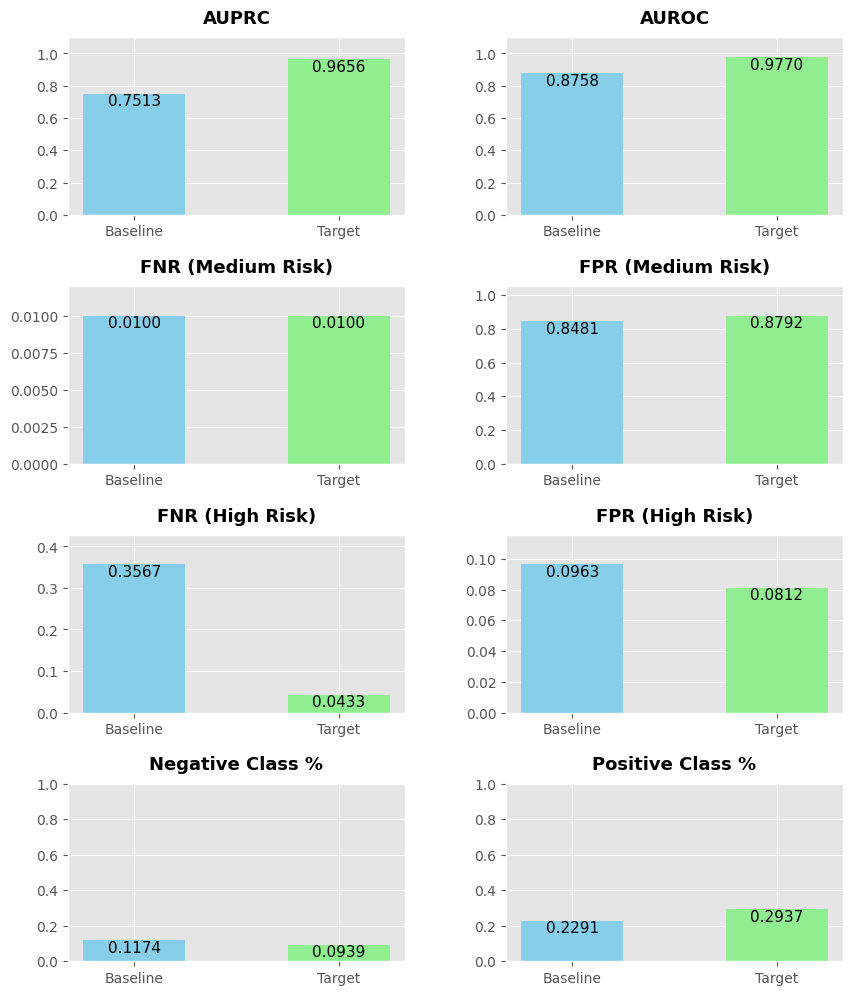

2025-03-30 20:31:18,818 - ClassifierEvaluation - INFO - Results plot saved as 'hp_ROBUST_CATBOOST.png'


In [14]:
y_binary = binarize_decision_class(y)

baseline_config = ModelConfig(
    name="Baseline",
    estimator_class="sklearn.linear_model.LogisticRegression",
    params={"random_state": RANDOM_STATE, "max_iter": 1000},
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

target_name = "hp_ROBUST_CATBOOST"
target_config = ModelConfig(
    name="Target",
    estimator_class="sklearn.pipeline.Pipeline",
    params={
        "steps": [
            ("scaler", RobustScaler()),
            (
                "classifier",
                CatBoostClassifier(
                    iterations=1000,
                    learning_rate=0.1,
                    depth=6,
                    random_state=RANDOM_STATE,
                    verbose=0,  # Suppress CatBoost's internal logging
                ),
            ),
        ]
    },
    scoring=ScoringConfig(func=roc_auc_score, kwargs={}),
)

_, _ = full_pipeline(
    X=X,
    y=y,
    target_config=target_config,
    baseline_config=baseline_config,
    target_name=target_name,
)

#### Przetwarzanie danych
Tak samo jak dla poprzedniego zbioru danych wartosci z kolumn Yes/No zostaly zamienione na 1 i 0, atrybuty kategoryczne nieporządkowe również zostały przekształcone przez kodowanie one-hot a te ze skali porządkowej przez OrdinalEncoder, dodatkowo atrybut "WBC" zostal usuniety ze zbioru danych poniewaz zawieral ponad 83% brakujacych wartosci. Atrybuty "NUMBER" i "HIP_REST" zostaly usuniete ze wzgledu na to ze nie wnosily zadnej informacji do zbioru danych. Dla pozostałych atrybutów numerycznych z brakujacymi wartosciami zastosowano imputacje z wykorzystaniem mediany. 


#### Modele i wyniki
Wszystkie modele zostaly przetrenowane na zbiorze treningowym i przetestowane na zbiorze testowym. Wykorzystano 5-fold cross-validation do oceny modeli. Jako baseline została wykorzystana regresja logistyczna, natomiast jako docelowy klasyfikator wybrano CatboostClassifier. W teorii skalowanie do metod opartych o drzewa gradientowe nie jest wymagane, jednak w tym przypadku (nauczony doswiadczeniem ze czasem to pomaga) zastosowano RobustScaler, dobrze dzialacy dla wartosci odstajacych. Catboost zostal wybrany jako obecnie jeden z najlepszych klasyfikatorow dla danych tabelarycznych.


AUPRC: Wzrost z 0.7513 do 0.9656 (poprawa o 28.5%) <br>
AUROC: Wzrost z 0.8758 do 0.9770 (poprawa o 11.6%)

Dla progu średniego ryzyka (czułość ≥ 99%):
- FNR_medium: Identyczne wartości (0.0100)
- FPR_medium: Niewielki wzrost z 0.8481 do 0.8792

Dla progu wysokiego ryzyka (specyficzność ≥ 90%):
- FNR_high: Znacząca poprawa z 0.3567 do 0.0433 (spadek o 87.9%)
- FPR_high: Nieznaczna poprawa z 0.0963 do 0.0812
- Odsetek negatywnych klasyfikacji: Spadek z 0.1174 do 0.0939 (spadek o 20.0%)
- Odsetek pozytywnych klasyfikacji: Wzrost z 0.2291 do 0.2937 (wzrost o 28.2%)

Wnioski

Model docelowy przewyższa model bazowy, szczególnie w zakresie AUPRC i AUROC, co wskazuje na lepszą zdolność rozróżniania klas. Najważniejszą poprawą jest drastyczne zmniejszenie współczynnika fałszywie negatywnych klasyfikacji (FNR_high) przy jednoczesnym zwiększeniu odsetka przypadków klasyfikowanych jako pozytywne.

# Zbiór sp_retro - Adam Wiatrowski 148510

In [15]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline
from scipy.stats import loguniform, uniform

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [16]:
SEED = 42
ITERS = 3
CV = 5

## Wczytanie danych

Zgodnie z opisem zadania:
> Klasa decyzyjna jest binaryzowana: **klasa pozytywna** to `'CONSULT'`, czyli przypadki wymagające konsultacji, natomiast **klasa negatywna** to wszystkie inne przypadki.

In [17]:
def load_dataset(
    path="../data/sp_retro_data.xls",
    sheet="Discretized Data (Final)",
    skiprows=2,
    na_values="?",
):
    df = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, na_values=na_values)

    X = df.drop(columns=["TRIAGE"])
    X = X.drop(columns=["NUMBER"])

    y = df["TRIAGE"].apply(lambda x: x == "CONSULT")

    return X, y

In [18]:
X, y = load_dataset()

## Wstępne przetwarzanie danych

Kolumny zawierające zbyt duży odsetek brakujących wartości są usuwane, aby poprawić jakość danych i uniknąć błędów podczas treningu.  
Następnie wszystkie zmienne kategoryczne są zamieniane na reprezentację binarną (`0/1`) przy użyciu kodowania one-hot (`pd.get_dummies`), co jest niezbędne dla modeli takich jak `BernoulliNB`, które wymagają danych binarnych.

In [19]:
def preprecess_data(data, delete_nans=False, threshold=0.7):
    X, y = data

    if delete_nans:
        missing_fraction = X.isnull().mean()
        X = X.loc[:, missing_fraction <= threshold]

    X = pd.get_dummies(X)

    return X, y

## Funkcje pomocnicze

In [20]:
def calculate_metrics(y_true, y_pred_proba, medium_threshold, high_threshold):
    """Calculate FNR, FPR and classification percentages."""
    y_pred_medium = (y_pred_proba >= medium_threshold).astype(int)
    y_pred_high = (y_pred_proba >= high_threshold).astype(int)

    tn_medium = np.sum((y_true == 0) & (y_pred_medium == 0))
    fp_medium = np.sum((y_true == 0) & (y_pred_medium == 1))
    fn_medium = np.sum((y_true == 1) & (y_pred_medium == 0))
    tp_medium = np.sum((y_true == 1) & (y_pred_medium == 1))

    tn_high = np.sum((y_true == 0) & (y_pred_high == 0))
    fp_high = np.sum((y_true == 0) & (y_pred_high == 1))
    fn_high = np.sum((y_true == 1) & (y_pred_high == 0))
    tp_high = np.sum((y_true == 1) & (y_pred_high == 1))

    fnr_medium = (
        fn_medium / (fn_medium + tp_medium) if (fn_medium + tp_medium) > 0 else 0
    )
    fpr_medium = (
        fp_medium / (fp_medium + tn_medium) if (fp_medium + tn_medium) > 0 else 0
    )
    fnr_high = fn_high / (fn_high + tp_high) if (fn_high + tp_high) > 0 else 0
    fpr_high = fp_high / (fp_high + tn_high) if (fp_high + tn_high) > 0 else 0

    y_classified = np.zeros_like(y_true, dtype=int) - 1  # -1 for gray area
    y_classified[y_pred_proba < medium_threshold] = 0  # Negative
    y_classified[y_pred_proba >= high_threshold] = 1  # Positive

    neg_percent = np.mean(y_classified == 0)
    pos_percent = np.mean(y_classified == 1)

    return {
        "fnr_medium": fnr_medium,
        "fpr_medium": fpr_medium,
        "fnr_high": fnr_high,
        "fpr_high": fpr_high,
        "neg_percent": neg_percent,
        "pos_percent": pos_percent,
    }


def find_threshold(y_true, y_scores, criterion="sensitivity", target_value=0.99):
    """Find threshold based on sensitivity or specificity target."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    if criterion == "sensitivity":
        valid_indices = np.where(tpr >= target_value)[0]
        if len(valid_indices) > 0:
            idx = valid_indices[0]
            return thresholds[idx]
        else:
            return min(thresholds)
    elif criterion == "specificity":
        specificity = 1 - fpr
        valid_indices = np.where(specificity >= target_value)[0]
        if len(valid_indices) > 0:
            idx = valid_indices[-1]
            return thresholds[idx]
        else:
            return max(thresholds)

In [21]:
def run_experiment(
    cls, dataset, iter=ITERS, cv=CV, seed=SEED, verbose=False, balance=False
):
    X, y = dataset
    rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=iter, random_state=seed)

    metrics_acc = {
        "auprc": [],
        "auroc": [],
        "fnr_medium": [],
        "fpr_medium": [],
        "fnr_high": [],
        "fpr_high": [],
        "neg_percent": [],
        "pos_percent": [],
    }

    for train_idx, test_idx in rskf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if balance:
            X_int = X.astype(int)
            sm = SMOTE(random_state=seed)
            X_train_bal, y_train_bal = sm.fit_resample(X_int, y)

            cls.fit(X_train_bal, y_train_bal)
        else:
            cls.fit(X_train, y_train)

        y_train_proba = cls.predict_proba(X_train)[:, 1]
        y_test_proba = cls.predict_proba(X_test)[:, 1]

        metrics_acc["auprc"].append(average_precision_score(y_test, y_test_proba))
        metrics_acc["auroc"].append(roc_auc_score(y_test, y_test_proba))

        # medium_t, high_t = find_threshold(y_train, y_train_proba)
        medium_t = find_threshold(y_train, y_train_proba, "sensitivity", 0.99)
        high_t = find_threshold(y_train, y_train_proba, "specificity", 0.90)

        fold_metrics = calculate_metrics(y_test, y_test_proba, medium_t, high_t)

        for k, v in fold_metrics.items():
            metrics_acc[k].append(v)

        if verbose:
            print({k: f"{np.mean(metrics_acc[k][-1:]):.3f}" for k in metrics_acc})

    print({k: f"{np.mean(metrics_acc[k][-1:]):.3f}" for k in metrics_acc})
    return {k: np.mean(metrics_acc[k][-1:]) for k in metrics_acc}

In [22]:
pipe = Pipeline([("smote", SMOTE(random_state=SEED)), ("clf", BernoulliNB())])

param_dist = {
    "clf__alpha": loguniform(1e-4, 10),
    "clf__binarize": uniform(0, 1),
    "clf__fit_prior": [True, False],
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="average_precision",
    cv=RepeatedStratifiedKFold(n_splits=CV, n_repeats=ITERS, random_state=SEED),
    n_jobs=-1,
    verbose=2,
    random_state=SEED,
)

X_pre, y_pre = preprecess_data((X, y))
X_pre = X_pre.astype(int)

rs.fit(X_pre, y_pre)

print("Score:", rs.best_score_)
print("Params:", rs.best_params_)

best_nb = rs.best_estimator_

Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.2s
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.1s
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.1s
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.1s
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.1s
[CV] END clf__alpha=0.0074593432857265485, clf__binarize=0.9507143064099162, clf__fit_prior=True; total time=   0.1s
[CV] END clf__alpha=0.7915074397656209, clf__binarize=0.596850157946487, clf__fit_prior=False; total time=   0.1s
[CV] END clf__alpha=0.7915074397656209, clf__binarize=0.596850157946487, clf__fit_prior=False; total time=   0.1s
[CV] EN

In [23]:
res_baseline = run_experiment(LogisticRegression(), dataset=(X_pre, y_pre))
res_target = run_experiment(
    best_nb, dataset=(preprecess_data((X, y), delete_nans=True)), balance=True
)

{'auprc': '0.724', 'auroc': '0.835', 'fnr_medium': '0.091', 'fpr_medium': '0.671', 'fnr_high': '0.364', 'fpr_high': '0.086', 'neg_percent': '0.296', 'pos_percent': '0.160'}
{'auprc': '0.793', 'auroc': '0.909', 'fnr_medium': '0.091', 'fpr_medium': '0.600', 'fnr_high': '0.273', 'fpr_high': '0.100', 'neg_percent': '0.358', 'pos_percent': '0.185'}


Zastosowano **BernoulliNB**, ponieważ dane wejściowe po zakodowaniu przy użyciu `get_dummies()` mają postać binarną (0/1). Model ten jest lekki, szybki i dobrze radzi sobie z dużą liczbą cech binarnych oraz dla niewielkich datasetów.

Ponieważ zbiór danych jest niezbalansowany, zastosowano **SMOTE** w celu zbalansowania rozkładu klas.

Dodatkowo, przeprowadzana jest optymalizacja hiperparametrów klasyfikatora BernoulliNB.

In [24]:
def show_result(res_baseline, res_target):
    labels = list(res_baseline.keys())

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
    axs = axs.flatten()

    for i, metric in enumerate(labels):
        ax = axs[i]
        # Rzutowanie na float dla bezpieczeństwa
        baseline_val = float(res_baseline[metric])
        target_val = float(res_target[metric])

        bars = ax.bar(
            ["Baseline", "Target"],
            [baseline_val, target_val],
            color=["skyblue", "lightgreen"],
        )

        ax.set_ylim(0, min(1, 1.5 * max(baseline_val, target_val)))
        ax.set_title(metric)

        for bar in bars:
            yval = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                yval + 0.01,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

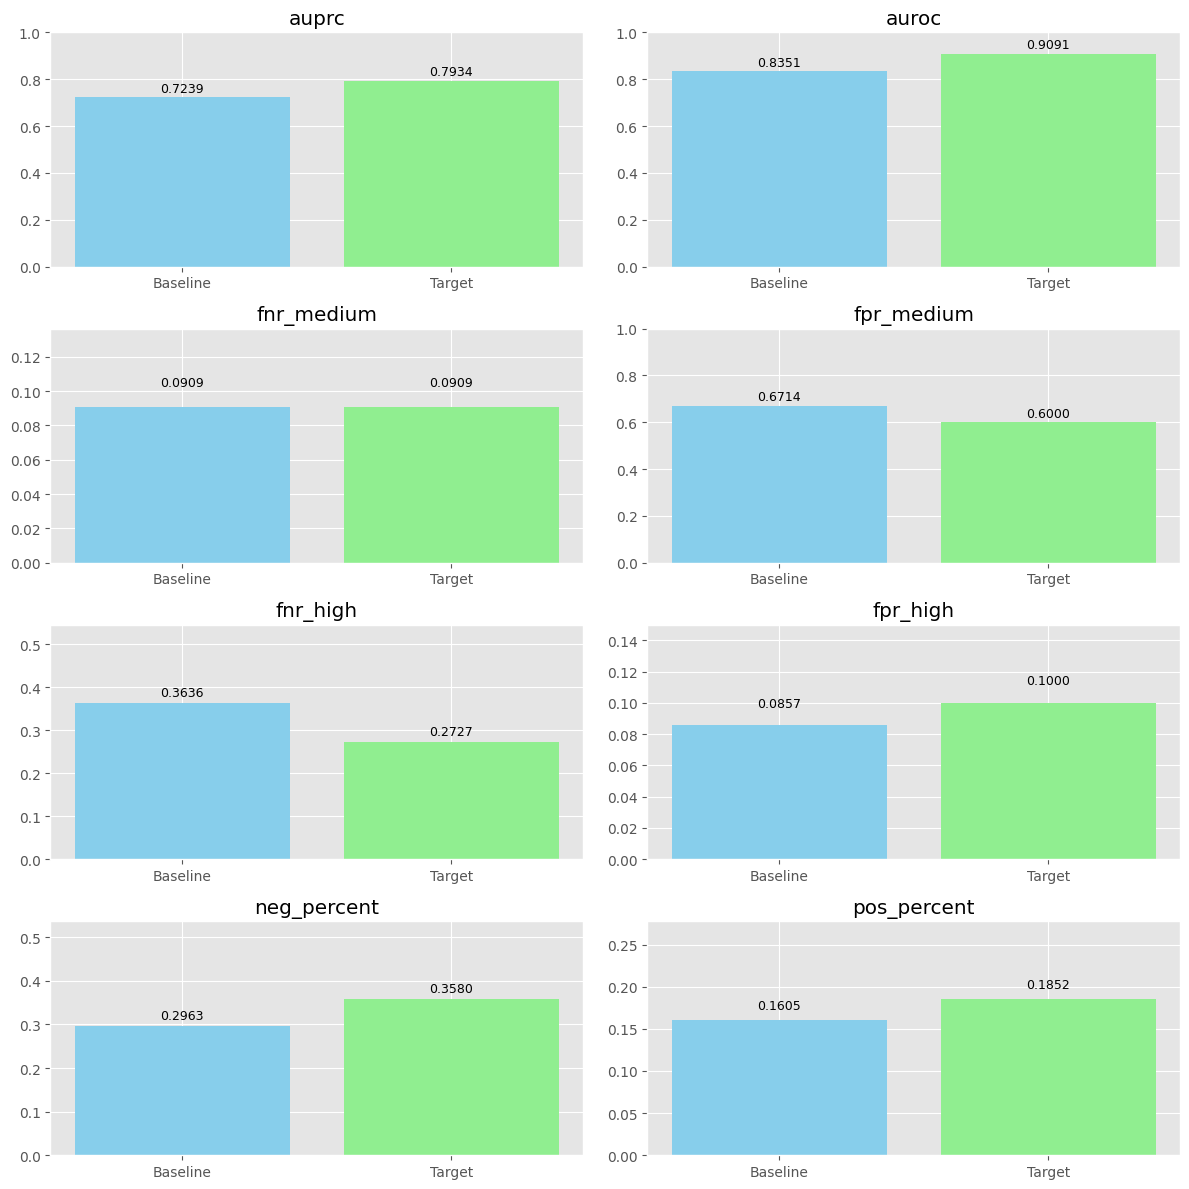

In [25]:
show_result(res_baseline, res_target)

## Interpretacja wyników:

1. AUPRC: 
> Proponowane roziwązanie osiąga lepsze wyniki na tej metryce, co wskazuje na lepszą jakość wykrywania klasy pozytywnej przy ograniczonej liczbie 'fałszywych alarmów', co jest szczególne istotne w przypadku danych niezbalansowanych.
2. AUROC: 
> Wyższy AUROC w modelu docelowym świadczy o lepszej zdolności rozróżniania między klasą pozytywną a negatywną.
3. FNR (MEDIUM): 
> FNR pozostał bez zmian, co oznacza, że oba modele mają podobną skuteczność w unikaniu pominięć przypadków średniego ryzyka.
4. FPR (MEDIUM): 
> Model docelowy popełnia mniej błędnych klasyfikacji pozytywnych wśród przypadków średniego ryzyka.
5. FNR (HIGH): 
> Znaczące obniżenie FNR wskazuje, że proponowany model lepiej wykrywa przypadki wysokiego ryzyka, zmniejszając ryzyko pomyłek typu false negative.
6. FPR (HIGH):
> Nieznaczny wzrost FPR oznacza więcej fałszywych alarmów w obszarze wysokiego ryzyka.